# Introduction

**Problem Statement:**

Skin cancer, particularly malignant melanoma, is a [public health concern globally, with over 325,000 cases and over 57,000 deaths due to melanoma in 2020.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8968696/#:~:text=Meaning,disproportionate%20mortality%20in%20transitioning%20countries.)

Early detection plays a crucial role in improving treatment outcomes and [reducing mortality rates associated with melanoma.](https://www.cancer.org/cancer/types/melanoma-skin-cancer/detection-diagnosis-staging/detection.html) The American Cancer Society recommends that people [perform skin self-exams once a month](https://www.cancer.org/cancer/types/melanoma-skin-cancer/detection-diagnosis-staging/detection.html) to check for melanoma, and to visit a doctor when new spots on the skin are found. 

However, differentiating between melanoma and benign skin lesions are [difficult even for clinicians](https://www.isic-archive.com/#!/topWithHeader/tightContentTop/about/aboutIsicBackground). Accessing specialized dermatological services for timely evaluation of skin lesions can also be challenging for the general public for various reasons, especially in remote or underserved areas. 

This often leads to delays in diagnosis and treatment, impacting [patient prognosis negatively](https://www.oncologynurseadvisor.com/home/cancer-types/melanoma/delaying-treatment-melanoma-mortality-risk-treatment/#:~:text=A%20population%2Dbased%20study%20found,associated%20with%20worse%20mortality%20outcomes.) and increasing [healthcare costs.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4495902/) Finally, if they do visit a doctor, and it turns out to be a false alarm, they would have wasted financial resources on consultation which may be costly. These are all problems which can be solved by what this project aims to produce.

**Objective:**

The objective of this project is to develop and deploy a highly accurate neural network model for the identification of benign and malignant skin lesions which will then be deployed to an app for usage by the general public. They would then be able to take a photo with their smartphones of any skin lesions to see if a doctor's visit is truly warranted based on the model rather than their own untrained judgement in detecting melanoma. By providing a reliable and accessible tool to the public for skin lesion assessment, it would help address the global burden of skin cancer, and contribute to improved healthcare outcomes worldwide.

`The model's performance will be evaluated based on its recall score.`

**Approach:**

1. Obtain image data on skin lesions that have been labelled as benign or malignant.
2. Use Transfer Learning as a starting point to train a neural network specialised for this task of classifying skin lesions.
3. Model deployment via Streamlit

# Imports

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # for plotting 
from PIL import Image # for showing images
import cv2 # for showing images
from sklearn.metrics import ConfusionMatrixDisplay, classification_report # for plotting of confusion matrix, and classification report

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array # to read in my dataset and for data augmentation
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetB3 # Pre-trained models for transfer learning
from tensorflow.keras.models import Sequential # Sequential class to sequentially build the model step-by-step
from tensorflow.keras.optimizers import Adam # Adam optimizer can still be used for CNNs
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping # to change the learning rate of neural network at certain epochs, and for earlystopping
from tensorflow.keras.metrics import Recall, Precision # scoring metrics to track

# Dense: fully connected layers for NNs model, Dropout: to add regularization,
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU


In [2]:
# Avoid Out Of Memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Data Collection

**The dataset's size is too large to be uploaded to github. It can instead be found at this [Google Drive link](https://drive.google.com/drive/folders/10GEoMsKyk4APUICyZDgOHwfNTtbkaxpY?usp=sharing)**. Please download the data set and put it in the same directory as the code folder in order for the code note books to run correctly.

1. The data for this project was obtained from the International Skin Imaging Collaboration (ISIC) which in their own words is ['an academia and industry partnership designed to facilitate the application of digital skin imaging to help reduce melanoma mortality'](https://www.isic-archive.com/#!/topWithHeader/tightContentTop/about/aboutIsicOverview). 

1. Their database contains over 70,000 images of skin lesions which have been contributed by [various medical universities and cancer centers](https://www.isic-archive.com/#!/topWithHeader/tightContentTop/about/isicArchiveContent). These images of skin lesions have been classified with [ground-truth diagnoses](https://www.isic-archive.com/#!/topWithHeader/tightContentTop/about/isicArchiveGoals) of whether it is benign or malignant.

1. [The images were downloaded through their API.](https://api.isic-archive.com/api/docs/swagger/) 

1. Out of these 70,000 images, I downloaded all images classified as malignant melanoma skin lesions which amounted to **6680**.

1. I downloaded 7500 images of benign skin lesions to get a relatively balanced dataset.

1. This gave me my relatively balanced dataset of 6680 images malignant melanoma and 7500 images of benign skin lesions which I will use to train my neural network.

## Caveat of the Dataset

The dataset used for training the neural network primarily comprises images of individuals with lighter skin tones, which introduces important considerations for stakeholders of this project. It is essential to acknowledge that the performance of the trained model on darker skin tones may present uncertainties.

The overrepresentation of lighter skin tones in the dataset can be attributed to the fact that melanoma is significantly more prevalent in individuals of white ethnicity compared to people of color, with a reported incidence rate [that is 20 times higher](https://www.medicalnewstoday.com/articles/skin-cancer-by-race#survival-rates). Consequently, the availability of a larger number of melanoma images on lighter skin tones might be a reflection of this higher incidence rate.

These observations underscore the need for cautious interpretation and generalization of the model's performance across different skin tones. 

## Splitting the Data

1. After acquiring the data, I split it into training, validation, and holdout set in the following ratio (70% training, 20% validation, 10% holdout)

1. I also split the data into its relevant folders(i.e. training, validation, or holdout folder), and within each folder, there are 3 folders which represent the class of the images inside the folder (e.g. benign folder with benign skin lesions inside it and malignant folder with malignant melanoma images inside it.) These folders can be found under the `data` folder.

# EDA

## Inspecting Original Images

With the data acquired, I can now perform EDA on the images.

Let's first show some images of each class to visually inspect it to see how different benign and malignant skin lesions look like.

**How to differentiate malignant melanoma vs benign skin lesions**

According to medical professionals, the way to identify moles / skin lesions is listed below. Let's see how easy it is to spot these differences

[The ABCDE Criteria can help you identify moles that could be malignant melanoma. Being aware of these criteria may very well save your life.](https://ololrmc.com/blogs/moles-when-should-i-worry#:~:text=Benign%20moles%20typically%20have%20a,get%20your%20mole%20checked%20out.&text=Benign%20moles%20are%20usually%20one%20uniform%20color%20throughout.)

A = Asymmetrical
If you look at a benign, or harmless, mole, it is usually symmetrical. On the other hand, a worrisome mole is asymmetrical, meaning if you cut in half, the two sides do not look the same.

B = Border
Benign moles typically have a regular, round border. Cancerous moles tend to have irregular borders. If the border isn’t smooth, you should get your mole checked out.

C = Color
Benign moles are usually one uniform color throughout. They can be brown, or black or pink, as long as they are one single color. Cancerous or pre-cancerous moles are multicolored. If the mole has more than one color, get it looked at.

D = Diameter
Imagine a pencil eraser. Moles smaller than the diameter of a pencil eraser are less likely to be cancer. If a mole is bigger than a pencil eraser, it is not necessarily cancerous, but it should be evaluated.

E = Evolving
The ABCD above is very important. However, if any mole on your skin shows signs of change, that can indicate a problem. A change in size or color for example might be the only sign that it is cancerous.


In [3]:
dir1 = '../data/benign_and_malignant/train/benign'
dir2 = '../data/benign_and_malignant/train/malignant'

In [4]:
benign_images = os.listdir(dir1)
malignant_images = os.listdir(dir2)

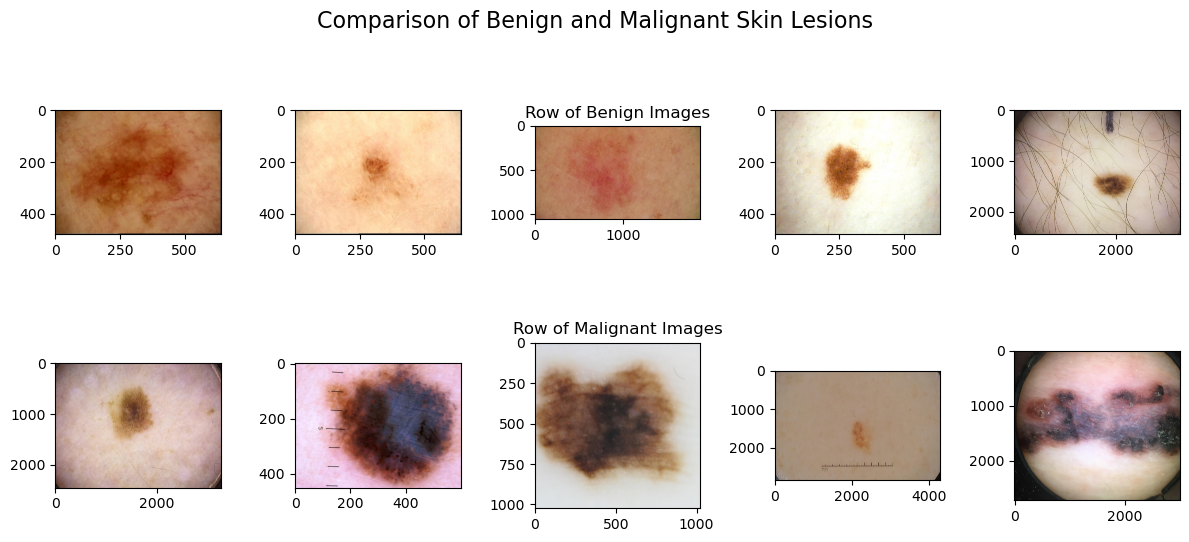

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

# Plot resized images from directory 1 (Benign)
for i in range(5):
    img_path1 = os.path.join(dir1, benign_images[i])
    img1 = Image.open(img_path1)
    axes[0, i].imshow(img1)

# Plot resized images from directory 2 (Malignant)
for i in range(5):
    img_path2 = os.path.join(dir2, malignant_images[i])
    img2 = Image.open(img_path2)
    axes[1, i].imshow(img2)

# setting title of plot
fig.suptitle('Comparison of Benign and Malignant Skin Lesions', fontsize=16, y=0.95)    
axes[0, 2].set_title('Row of Benign Images', loc='center')
axes[1, 2].set_title('Row of Malignant Images', loc='center')

plt.tight_layout()
plt.show();


**From the output above, we can see that the images do generally fit the ABCDE criteria, but it is also understandable how the public may have difficulties in identifying it on their own.** 

1. For example, the malignant images do have irregular borders especially the image in the 2nd row, 5th column. However, there are images of benign lesions which are also asymmetrical.


**This is a good sign that a neural network model will be able to pick up on this hard to identify differences which the untrained eye may not be able to.**

The next thing to note is that the images are of varied sizes, note the images in the 2nd row, 4th and 5th columns. They are extremely large in size compared to some of the other images.

**I will need to resize all of the images to a standard size. This is as the pre-trained models I will be using later on were trained on images of size (224,224).**

Resizing the images to match what the pre-trained models were trained on will ensure that my images align with the expected input shape of the pre-trained models, thereby allowing for proper feature extraction and classification.

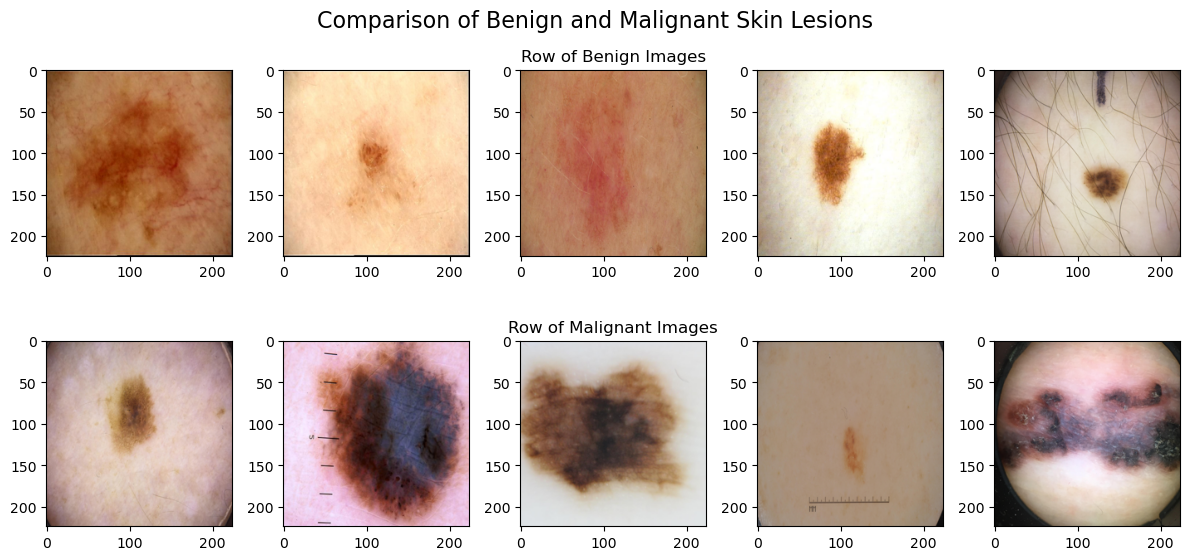

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

# Plot resized images from directory 1 (Benign)
for i in range(5):
    img_path1 = os.path.join(dir1, benign_images[i])
    img1 = Image.open(img_path1)
    img1_resized = img1.resize((224, 224))
    axes[0, i].imshow(img1_resized)

# Plot resized images from directory 2 (Malignant)
for i in range(5):
    img_path2 = os.path.join(dir2, malignant_images[i])
    img2 = Image.open(img_path2)
    img2_resized = img2.resize((224, 224))
    axes[1, i].imshow(img2_resized)

# setting title of plot
fig.suptitle('Comparison of Benign and Malignant Skin Lesions', fontsize=16, y=0.95)    
axes[0, 2].set_title('Row of Benign Images', loc='center')
axes[1, 2].set_title('Row of Malignant Images', loc='center')

plt.tight_layout()
plt.show()


Visualisation of how the resized images look. Notice that all of the images are of size 224,224. **I will perform this resizing for all images when I am loading in the data before modelling.**

## Inspecting Color Channel Intensities amongst Classes

Besides visually inspecting the images, I will now check to see if the color intensities are different amongst the two classes. I will define a function which returns the average of each color channel intensity (RGB) for each class.

I am expecting that the results will show that the classes do indeed have different color channel intensities.

In [7]:
# defining the function
def calculate_channel_average(image_dir, channel):
    """
    Calculate channel average for skin lesion images in the given directory.
    """
    channel_dict = {"R": 2, "G": 1, "B": 0} #note that cv2.imread reads in images in BGR format and not RGB, hence them being assigned these specific numbers.
    channel_idx = channel_dict[channel] # to indicate which layer to grab the pixels from
    channel_intensities = [] # empty list to add the mean color channel intensity for each image

    # Iterate over the images in the directory
    for image_file in os.listdir(image_dir): # looping over the images in a particular directory (i.e. benign or malignant)
        image_path = os.path.join(image_dir, image_file) # getting the full image path for each image

        try:
            image = cv2.imread(image_path) # reading in the image
            if image is None: # in case there are files which are not images
                print(f"Unable to read image file: {image_file}") # to help me identify which files if any are causing errors for me to remove.
                continue

            channel_intensity = np.mean(image[:, :, channel_idx]) # grabbing the mean value of the particular color channel that I want
            channel_intensities.append(channel_intensity)# appending the mean value for the particular color channel of that one image
        except: 
            print(f"Error processing image file: {image_file}")
            

    return np.mean(channel_intensities)# return the mean value of the particular color channel of all images of a particular class

In [8]:
# Calculating channel average over benign labels and storing it in variables
red_channel_average_benign = calculate_channel_average(dir1, "R")# recall dir1 points to benign directory
green_channel_average_benign = calculate_channel_average(dir1, "G")
blue_channel_average_benign = calculate_channel_average(dir1, "B")

# Calculating channel average over malignant labels and storing it in variables
red_channel_average_malignant = calculate_channel_average(dir2, "R") # recall dir2 points to malignant directory
green_channel_average_malignant = calculate_channel_average(dir2, "G")
blue_channel_average_malignant = calculate_channel_average(dir2, "B")


Unable to read image file: .DS_Store
Unable to read image file: .DS_Store
Unable to read image file: .DS_Store
Unable to read image file: .DS_Store
Unable to read image file: .DS_Store
Unable to read image file: .DS_Store


The function has finished running, and I now have my variables with the values I'm interested in. Also note that I have some files inside which are not image files. I will clean this up later. First to visualise the color channel intensity across the classes.

In [9]:
#creating a dataframe with the values for easy visualisation
data = {
    'Color': ['Red', 'Green', 'Blue', 'Red', 'Green', 'Blue'],
    'Intensity': [
        red_channel_average_benign, green_channel_average_benign, blue_channel_average_benign,
        red_channel_average_malignant, green_channel_average_malignant, blue_channel_average_malignant
    ],
    'Class': ['Benign', 'Benign', 'Benign', 'Malignant', 'Malignant', 'Malignant']
}

df = pd.DataFrame(data)
df

,Color,Intensity,Class
0,Red,184.871007,Benign
1,Green,143.840753,Benign
2,Blue,120.264939,Benign
3,Red,154.440168,Malignant
4,Green,128.601777,Malignant
5,Blue,123.243798,Malignant


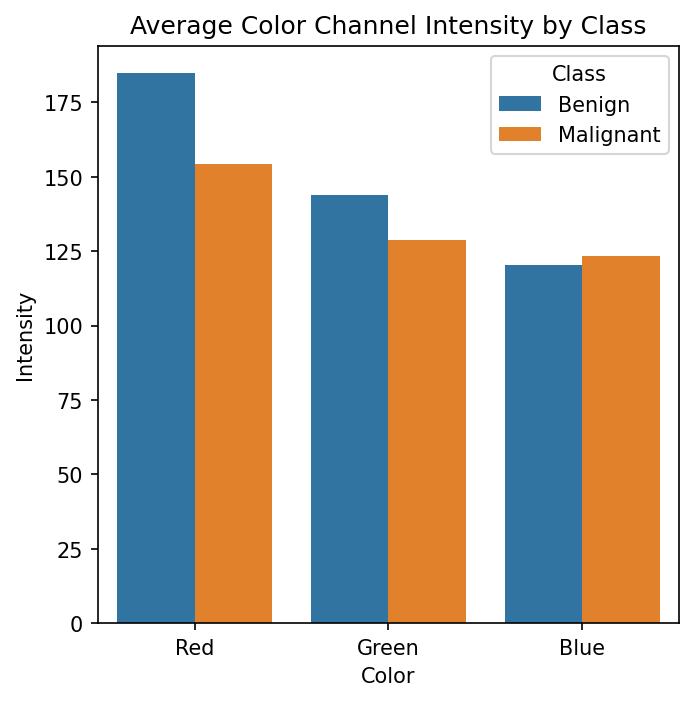

In [10]:
plt.figure(figsize=(5,5),dpi=150)
# Plot the bar plot
sns.barplot(data=df, x='Color', y='Intensity', hue='Class')

# Set the plot labels and title
plt.xlabel('Color')
plt.ylabel('Intensity')
plt.title('Average Color Channel Intensity by Class')

# Show the plot
plt.show();

From the plot above, we can see that there is indeed a difference between the color channel intensities of the red and green layer between the two classes. This is a good sign that a neural network will be able to pick up on these differences and that model performance should be good. I will now move on to preprocessing such as resizing images and removing files that are not images as previously mentioned.

# Preprocessing

1. I will be reading in the train, validation, and holdout data using ImageDataGenerator().flow_from_directory. [This method only takes in files with image file extensions (e.g. jpg, png, etc.), and excludes files without these extensions.](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) As such, the non-image file (i.e. .DS_STORE) that was previously identified by the function when calculating channel color intensity will not be read in.
    1. This accomplishes not reading in non-image files for my dataset.
1. Next, I have also included the target_size parameter as (224,224) for reasons previously described. This will automatically resize all my images to size (224,224) which is what I require.
    1. This accomplishes the resizing of all images that I previously identified was necessary.

In [11]:
# Loading the Train, Validation, and Holdout data
train_data = ImageDataGenerator().flow_from_directory('../data/benign_and_malignant/train/',
                                                      target_size=(224,224),#note the target size of (224,224) 
                                                      class_mode='binary'
                                                     )

val_data = ImageDataGenerator().flow_from_directory('../data/benign_and_malignant/validation/', 
                                                    target_size=(224,224), #note the target size of (224,224) 
                                                    class_mode='binary'
                                                   )

holdout_data = ImageDataGenerator().flow_from_directory('../data/benign_and_malignant/holdout/', 
                                                        target_size=(224,224), #note the target size of (224,224) 
                                                        class_mode='binary',
                                                        shuffle = False # shuffle is set to False, for classification purposes later so that the predicted values match the labels of the holdout set
                                                       )


Found 9926 images belonging to 2 classes.
Found 2836 images belonging to 2 classes.
Found 1418 images belonging to 2 classes.


**Reminder on how I split the data**

1. After acquiring the data, I split it into training, validation, and holdout set in the following ratio (70% training, 20% validation, 10% holdout)

1. I also split the data into its relevant folders(i.e. training, validation, or holdout folder), and within each folder, there are 2 folders which represent the class of the images inside the folder (i.e. benign folder with benign skin lesions inside it and malignant folder with malignant melanoma images inside it. These folders can be found under the `data` folder.

When I was splitting the data, I already split the data so that it had balanced classes, but to show it in the notebook as well.

In [12]:
# Check the classes that ImageDataGenerator was able to find using .class_indices
class_mappings = train_data.class_indices
print(class_mappings) # shows us that 'benign'->assigned to class 0, 'malignant'->assigned to class 1

{'benign': 0, 'malignant': 1}


In [13]:
np.bincount(train_data.classes) # to get the number of images in each class. 5373 images belong to class 0, 4553 images belong to class 1 of the training directory

array([5373, 4553])

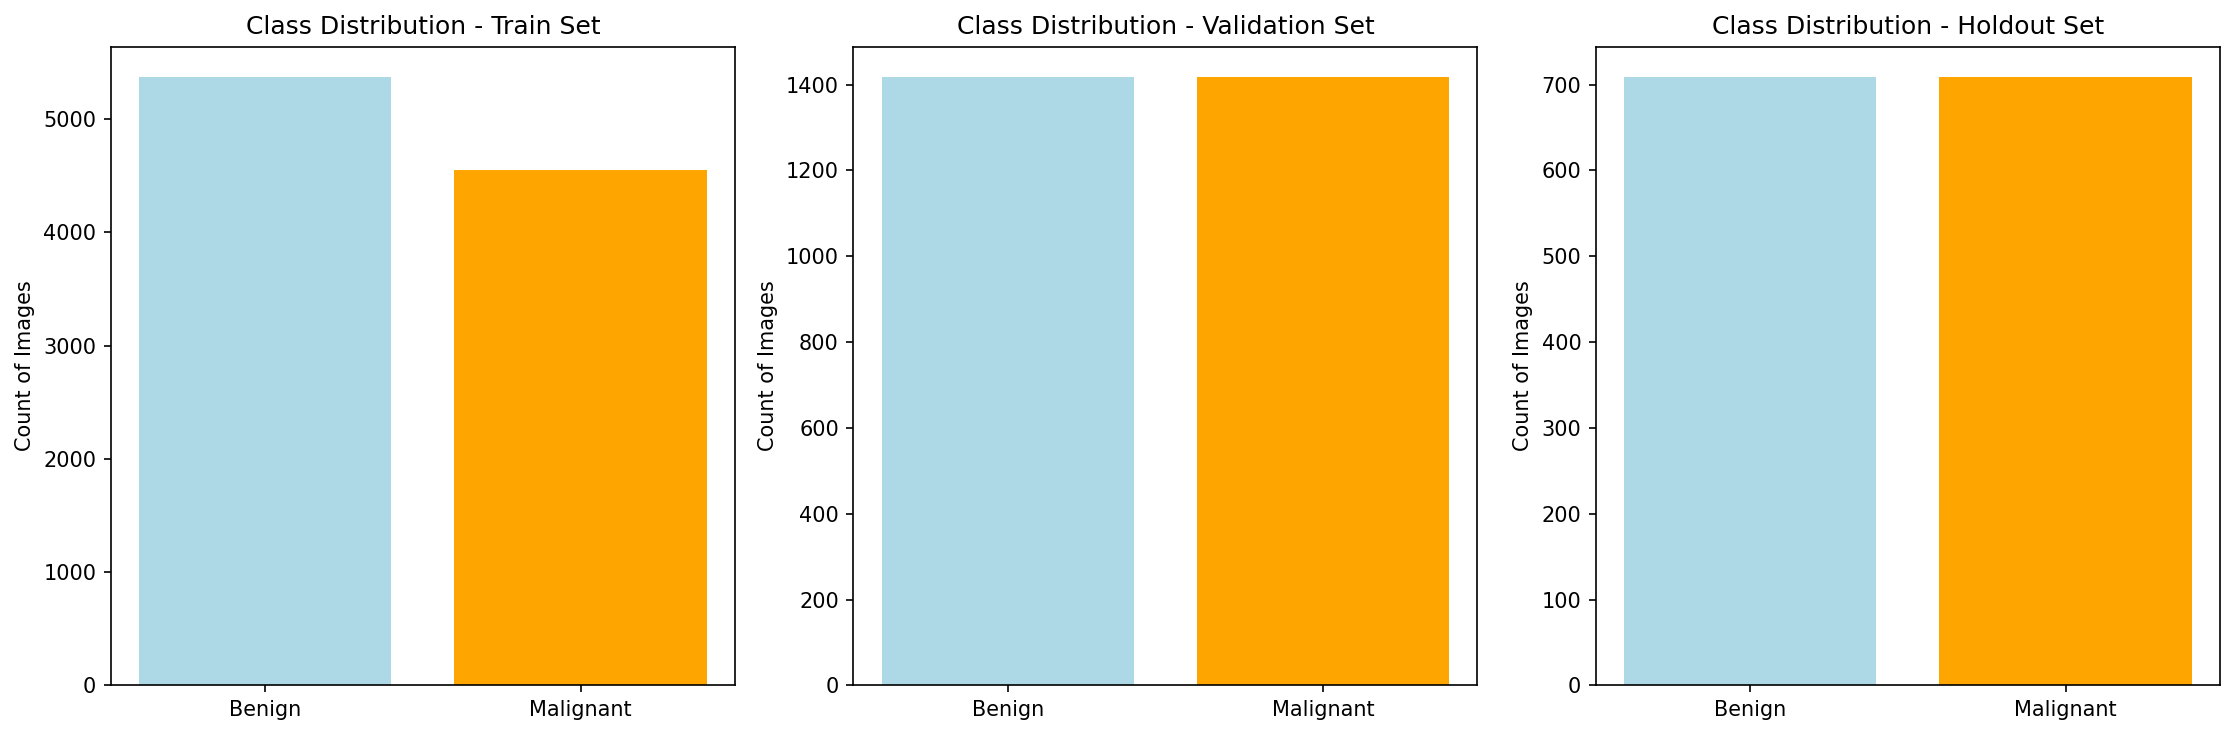

In [14]:

# Get the class counts for each dataset
train_class_counts = np.bincount(train_data.classes)
val_class_counts = np.bincount(val_data.classes)
holdout_class_counts = np.bincount(holdout_data.classes)

# Define the class labels
class_labels = ['Benign', 'Malignant']

# Define the colors for the bars
colors = ['lightblue', 'orange']

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5),dpi=150)

# Plot the class distributions for each dataset
axes[0].bar(class_labels, train_class_counts, color=colors)
axes[1].bar(class_labels, val_class_counts, color=colors)
axes[2].bar(class_labels, holdout_class_counts, color=colors)

# Set titles and labels for each plot
axes[0].set_title('Class Distribution - Train Set')
axes[0].set_ylabel('Count of Images')
axes[1].set_title('Class Distribution - Validation Set')
axes[1].set_ylabel('Count of Images')
axes[2].set_title('Class Distribution - Holdout Set')
axes[2].set_ylabel('Count of Images')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show();


Note the balanced classes for my validation set and holdout set, and the relatively balanced classes for my train set as well.

This means that even if my model was predicting everything as a particular class, it would still only get a score of 50%.

Any recall score I get above 50% will be an improvement on a blind guess.

# Modelling

To begin my modelling process. I first identified two pre-trained models which were both state-of-the-art, and had a good balance between accuracy and model size.

Thus, I identified MobileNetv3 and EfficientNetB3 as the pre-trained models I would use for this project.

MobileNetV3 has been shown to give [SOTA results in major computer vision problems.](https://towardsdatascience.com/everything-you-need-to-know-about-mobilenetv3-and-its-comparison-with-previous-versions-a5d5e5a6eeaa)

EfficientNet models are a family of models developed by Google which achieved [SOTA accuracy on multiple datasets](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html). As to why B3 specifically, and not B4 or B2. I believe B3 balances model complexity and accuracy the best for my project. [For example B3 has 12.3 million parameters compared to 19.5 parameters in B4 but only having a 0.7% increase in Top-5 accuracy on the ImageNet validation dataset.](https://keras.io/api/applications/) As such, I will use the B3 version of the EfficientNet models.

## Baseline Model

With my pre-trained models identified, I will first run the data through each pre-trained model to see which gives better performance, and the subsequent improved models will be based on that pre-trained model.

I will first start with MobileNetV3.

### MobileNetV3

[**Note that scaling happens automatically in MobileNetV3 hence why I have not scaled the values beforehand.**](https://keras.io/api/applications/mobilenet/#mobilenetv2-function)

In [15]:
# Importing my desired pre-trained transfer learning model, MobileNetV3Large
pre_trained_model = MobileNetV3Large(include_top=False, pooling='avg') #exclude the classification head from pre-trained model, global pooling set to avg

# Freezing the model so I don't accidentally change the pre-trained model parameters during dense layer gradient descent
pre_trained_model.trainable = False

Metal device set to: Apple M1


2023-05-28 19:30:23.220632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-28 19:30:23.220908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
# Create our FNN model architecture
trf_model = Sequential() # instantiate empty sequential model using Sequential class

# Then add the pre-trained model to use Transfer Learning, get all the weights from pre_trained_model
trf_model.add(pre_trained_model) # pre_trained_model = input CNN layers

# Taking the 1-D vector output from MobileNetV3Large & use logistic regression classification head to classify benign vs malignant
trf_model.add(Dense(1, activation='sigmoid')) # dense 1 layer & activation = 'sigmoid' for binary classification

trf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________


In [17]:
# Compile the model
trf_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[Recall()])  
# specify Adam optimizer, binary_crossentropy loss function for a binary classification task, and my targeted metric of recall

In [18]:
# Fit model on training data (fit model and save results to history)
history = trf_model.fit(train_data, # train_data created using ImageDataGenerator class for model training (X, y split internally)
                        batch_size=64, 
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation (X, y split internally)
                        epochs=5,
                       )

Epoch 1/5


2023-05-28 19:30:24.909009: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-28 19:30:26.369464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - ETA: 0s - loss: 0.3599 - recall: 0.7935

2023-05-28 19:31:35.172422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - 107s 336ms/step - loss: 0.3599 - recall: 0.7935 - val_loss: 0.3625 - val_recall: 0.7913
Epoch 2/5
311/311 [==============================] - 103s 332ms/step - loss: 0.2703 - recall: 0.8528 - val_loss: 0.3510 - val_recall: 0.7983
Epoch 3/5
311/311 [==============================] - 106s 340ms/step - loss: 0.2500 - recall: 0.8636 - val_loss: 0.3352 - val_recall: 0.8357
Epoch 4/5
311/311 [==============================] - 108s 346ms/step - loss: 0.2386 - recall: 0.8713 - val_loss: 0.3210 - val_recall: 0.8336
Epoch 5/5
311/311 [==============================] - 108s 348ms/step - loss: 0.2325 - recall: 0.8728 - val_loss: 0.3355 - val_recall: 0.8138


**Here are the results of this model**

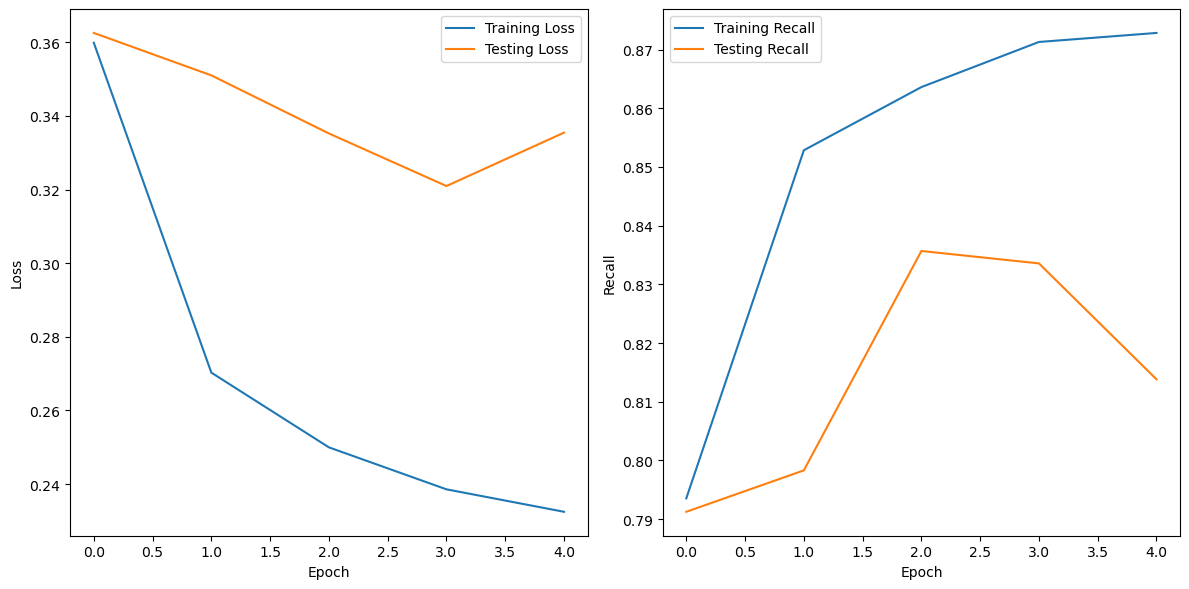

In [19]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_recall = history.history['recall']
test_recall = history.history['val_recall']


# Set figure size and create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot training and testing loss
axes[0].plot(train_loss, label='Training Loss')
axes[0].plot(test_loss, label='Testing Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot training and testing recall
axes[1].plot(train_recall, label='Training Recall')
axes[1].plot(test_recall, label='Testing Recall')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Recall')
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


From the results of the model as well as from the plots above, it is evident that there is overfitting in this model, which is to be expected. I will address this issue in subsequent models after first identifying which pre-trained model has better baseline performance in terms of recall.

Moving on to try EfficientNetB3.

### EfficientNetB3

[**Note that scaling happens automatically in EfficientNetB3 as well, hence why I have not scaled the values beforehand.**](https://keras.io/api/applications/efficientnet/#efficientnetb3-function)

In [20]:
# Importing my desired pre-trained transfer learning model, EfficientNetB3
pre_trained_model = EfficientNetB3(include_top=False, pooling='avg') #exclude the classification head from pre-trained model, global pooling set to avg

# Freezing the model so I don't accidentally change the pre-trained model parameters during dense layer gradient descent
pre_trained_model.trainable = False

In [21]:
# Create our FNN model architecture
trf2_model = Sequential() # instantiate empty sequential model using Sequential class

# Then add the pre-trained model to use Transfer Learning, get all the weights from pre_trained_model
trf2_model.add(pre_trained_model) # pre_trained_model = input CNN layers

# Taking the 1-D vector output from EfficientNetB3 & use logistic regression classification head to classify benign vs malignant
trf2_model.add(Dense(1, activation='sigmoid')) # dense 1 layer & activation = 'sigmoid' for binary classification

trf2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense_1 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 10,785,072
Trainable params: 1,537
Non-trainable params: 10,783,535
_________________________________________________________________


In [22]:
# Compile the model
trf2_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[Recall()])  
# specify Adam optimizer, binary_crossentropy loss function for a binary classification task, and my targeted metric of recall

In [23]:
# Fit model on training data (fit model and save results to history)
efficient_net_history = trf2_model.fit(train_data, # train_data created using ImageDataGenerator class for model training (X, y split internally)
                        batch_size=64, 
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation (X, y split internally)
                        epochs=5,
                       )

Epoch 1/5


2023-05-28 19:39:23.693004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - ETA: 0s - loss: 0.3686 - recall_1: 0.7733

2023-05-28 19:41:52.515155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - 211s 658ms/step - loss: 0.3686 - recall_1: 0.7733 - val_loss: 0.4069 - val_recall_1: 0.7123
Epoch 2/5
311/311 [==============================] - 202s 647ms/step - loss: 0.3029 - recall_1: 0.8340 - val_loss: 0.3729 - val_recall_1: 0.7454
Epoch 3/5
311/311 [==============================] - 214s 686ms/step - loss: 0.2865 - recall_1: 0.8465 - val_loss: 0.3609 - val_recall_1: 0.7546
Epoch 4/5
311/311 [==============================] - 215s 692ms/step - loss: 0.2786 - recall_1: 0.8465 - val_loss: 0.3236 - val_recall_1: 0.8188
Epoch 5/5
311/311 [==============================] - 216s 693ms/step - loss: 0.2703 - recall_1: 0.8528 - val_loss: 0.3058 - val_recall_1: 0.8547


**Here are the results of this model**

## Improved Model #1

In [24]:
print(f'The mean recall score for MobileNetV3 is {np.mean(history.history["val_recall"])}')
print(f'The mean recall score for EfficientNetB3 is {np.mean(efficient_net_history.history["val_recall_1"])}')

The mean recall score for MobileNetV3 is 0.8145274996757508
The mean recall score for EfficientNetB3 is 0.7771509051322937


After trying both pre-trained models, I have decided to use MobileNetV3 as the pre-trained model. I have selected it based on the following reasons:

1. The mean recall score for MobileNetV3 is better than EfficientNetB3.
1. The time taken to train the MobileNetV3 was significantly quicker due to it being a less complex model with less parameters.
1. In the context of my problem statement which aims to deploy this model, having a model which is less computationally intensive is a positive. Having a less complex model also helps to reduce the chances of overfitting which are issues that neural networks constantly run into.

For these reasons, I will be choose MobileNetV3 as the pre-trained model for future improvements.

**The first change I will make is to change the global pooling layer to be max instead of avg to see if it increases recall score.**

### Global Max Pooling

In [25]:
# Importing my desired pre-trained transfer learning model, MobileNetV3Large
pre_trained_model = MobileNetV3Large(include_top=False, pooling='max') #exclude the classification head from pre-trained model, notice global pooling is set to max now

# Freezing the model so I don't accidentally change the pre-trained model parameters during dense layer gradient descent
pre_trained_model.trainable = False

In [26]:
# Create our FNN model architecture
trf_model = Sequential() # instantiate empty sequential model using Sequential class

# Then add the pre-trained model to use Transfer Learning, get all the weights from pre_trained_model
trf_model.add(pre_trained_model) # pre_trained_model = input CNN layers

# Taking the 1-D vector output from MobileNetV3Large & use logistic regression classification head to classify benign vs malignant
trf_model.add(Dense(1, activation='sigmoid')) # dense 1 layer & activation = 'sigmoid' for binary classification

trf_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________


In [27]:
# Compile the model
trf_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[Recall()])  
# specify Adam optimizer, binary_crossentropy loss function for a binary classification task, and my targeted metric of recall.

In [28]:
# Fit model on training data (fit model and save results to history)
improved1_history = trf_model.fit(train_data, # train_data created using ImageDataGenerator class for model training (X, y split internally)
                        batch_size=64, 
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation (X, y split internally)
                        epochs=5,
                       )

Epoch 1/5


2023-05-28 19:57:01.011662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - ETA: 0s - loss: 0.8995 - recall_2: 0.7711

2023-05-28 19:58:20.664809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - 121s 377ms/step - loss: 0.8995 - recall_2: 0.7711 - val_loss: 0.8331 - val_recall_2: 0.7532
Epoch 2/5
311/311 [==============================] - 111s 355ms/step - loss: 0.5072 - recall_2: 0.8405 - val_loss: 0.8022 - val_recall_2: 0.6566
Epoch 3/5
311/311 [==============================] - 111s 356ms/step - loss: 0.4004 - recall_2: 0.8550 - val_loss: 0.5839 - val_recall_2: 0.7701
Epoch 4/5
311/311 [==============================] - 111s 356ms/step - loss: 0.3492 - recall_2: 0.8636 - val_loss: 0.7032 - val_recall_2: 0.6530
Epoch 5/5
311/311 [==============================] - 111s 356ms/step - loss: 0.3146 - recall_2: 0.8724 - val_loss: 0.5899 - val_recall_2: 0.7306


In [29]:
print(f'The mean recall score for MobileNetV3 with Global Average Pooling is {np.mean(history.history["val_recall"])}')
print(f'The mean recall score for MobileNetV3 with Global Max Pooling is {np.mean(improved1_history.history["val_recall_2"])}')

The mean recall score for MobileNetV3 with Global Average Pooling is 0.8145274996757508
The mean recall score for MobileNetV3 with Global Max Pooling is 0.7126939296722412


The mean recall score is worse compared to when the global pooling layer was avg. I will revert back to using Global Average Pooling for future models.

The score for global max pooling could be worse due to the fact that the images of benign and malignant skin lesions are quite similar and global max pooling does a poorer job compared to global average pooling in extracting the important features.

## Improved Model #2

### Increasing Hidden Layers

Now that the global pooling layer has been decided, I will try and improve model performance by doing the following.

1. Increasing hidden layers to help the model learn more complex representations in the data. As skin lesions are complex images, introducing more hidden layers should be better able to capture the intricate patterns in the data.

1. I will include dropout layers to mitigate overfitting.

1. I will include batchnormalization layers to improve [learning speed and also to mitigate overfitting.](https://www.baeldung.com/cs/batch-normalization-cnn#:~:text=Batch%20Norm%20is%20a%20normalization,learning%20rates%2C%20making%20learning%20easier.&text=the%20standard%20deviation%20of%20the%20neurons'%20output.)

1. I will also include earlystopping in future models, to save time on training.

1. I will also train the model for longer epochs to try and improve model performance.


In [30]:
# Importing my desired pre-trained transfer learning model, MobileNetV3Large
pre_trained_model = MobileNetV3Large(include_top=False, pooling='avg') #exclude the classification head from pre-trained model, global pooling set back to avg

# Freezing the model so I don't accidentally change the pre-trained model parameters during dense layer gradient descent
pre_trained_model.trainable = False

In [31]:
# Create our FNN model architecture
trf_model = Sequential() # instantiate empty sequential model using Sequential class

# Then add the pre-trained model to use Transfer Learning, get all the weights from pre_trained_model
trf_model.add(pre_trained_model) # pre_trained_model = input CNN layers

trf_model.add(Dropout(0.5)) #dropout layer, 50% of input units will be set to 0
trf_model.add(Dense(960,activation = 'relu'))  
trf_model.add(BatchNormalization()) #batchnormaliation layer
trf_model.add(Dense(512,activation = 'relu'))
trf_model.add(Dense(1, activation='sigmoid')) # dense 1 layer & activation = 'sigmoid' for binary classification

trf_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense_3 (Dense)             (None, 960)               922560    
                                                                 
 batch_normalization (BatchN  (None, 960)              3840      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 512)               492032    
                                                                 
 dense_5 (Dense)             (None, 1)                

In [32]:
# Compile the model
trf_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[Recall()])  
# specify Adam optimizer, binary_crossentropy loss function for a binary classification task, and my targeted metric of recall.

#creating my early stop
early_stopping = EarlyStopping(monitor='val_recall_3', patience=3, mode='max')#monitor my recall score, stops training if after 3 epochs there's no improvement.

In [33]:
# Fit model on training data (fit model and save results to history)
improved2_history = trf_model.fit(train_data, # train_data created using ImageDataGenerator class for model training (X, y split internally)
                        batch_size=64, 
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation (X, y split internally)
                        epochs=10,# increased the number of epochs since there's early stopping
                        callbacks=[early_stopping] # early stopping callback
                       )

Epoch 1/10


2023-05-28 20:06:26.399956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - ETA: 0s - loss: 0.4145 - recall_3: 0.8019

2023-05-28 20:07:44.234634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - 119s 371ms/step - loss: 0.4145 - recall_3: 0.8019 - val_loss: 0.3035 - val_recall_3: 0.8131
Epoch 2/10
311/311 [==============================] - 112s 358ms/step - loss: 0.2926 - recall_3: 0.8326 - val_loss: 0.3301 - val_recall_3: 0.7687
Epoch 3/10
311/311 [==============================] - 113s 364ms/step - loss: 0.2684 - recall_3: 0.8386 - val_loss: 0.3252 - val_recall_3: 0.7708
Epoch 4/10
311/311 [==============================] - 113s 364ms/step - loss: 0.2527 - recall_3: 0.8544 - val_loss: 0.3195 - val_recall_3: 0.7729


Unfortunately the score is worse than the baseline model. I will increase the number of hidden layers further to try and improve model performance.

## Improved Model #3

### Increasing Hidden Layers 

In [34]:
# Create our FNN model architecture
trf_model = Sequential() # instantiate empty sequential model using Sequential class

# Then add the pre-trained model to use Transfer Learning, get all the weights from pre_trained_model
trf_model.add(pre_trained_model) # pre_trained_model = input CNN layers

trf_model.add(Dropout(0.5))
trf_model.add(Dense(960,activation = 'relu'))
trf_model.add(BatchNormalization())
trf_model.add(Dense(512,activation = 'relu'))
trf_model.add(BatchNormalization())
trf_model.add(Dense(512,activation = 'relu'))
trf_model.add(Dense(256,activation = 'relu'))
trf_model.add(Dense(1, activation='sigmoid')) # dense 1 layer & activation = 'sigmoid' for binary classification

trf_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 960)               0         
                                                                 
 dense_6 (Dense)             (None, 960)               922560    
                                                                 
 batch_normalization_1 (Batc  (None, 960)              3840      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 512)               492032    
                                                                 
 batch_normalization_2 (Batc  (None, 512)             

In [35]:
# Compile the model
trf_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[Recall()])  
# specify Adam optimizer, binary_crossentropy loss function for a binary classification task, and my targeted metrics of recall.

In [36]:
early_stopping = EarlyStopping(monitor='val_recall_4', patience=3, mode='max')#monitor my recall score, stops training if after 3 epochs there's no improvement.

In [37]:
# Fit model on training data (fit model and save results to history)
improved3_history = trf_model.fit(train_data, # train_data created using ImageDataGenerator class for model training (X, y split internally)
                        batch_size=64, 
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation (X, y split internally)
                        epochs=10, # increased the number of epochs since there's early stopping
                        callbacks=[early_stopping] # early stopping callback
                       )

Epoch 1/10


2023-05-28 20:14:04.370715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - ETA: 0s - loss: 0.3588 - recall_4: 0.7982

2023-05-28 20:15:27.863405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - 126s 391ms/step - loss: 0.3588 - recall_4: 0.7982 - val_loss: 0.3612 - val_recall_4: 0.7708
Epoch 2/10
311/311 [==============================] - 112s 359ms/step - loss: 0.2965 - recall_4: 0.8232 - val_loss: 0.4220 - val_recall_4: 0.6199
Epoch 3/10
311/311 [==============================] - 112s 361ms/step - loss: 0.2734 - recall_4: 0.8291 - val_loss: 0.3358 - val_recall_4: 0.7673
Epoch 4/10
311/311 [==============================] - 112s 359ms/step - loss: 0.2577 - recall_4: 0.8539 - val_loss: 0.3069 - val_recall_4: 0.7666


**Even with more hidden layers, the performance is still poorer than the baseline model. The pre-trained model may be enough to get the best performance and no hidden layers are needed.**

## Improved Model #4

### Data Augmentation & More Epoch & Learning Rate Scheduler

1. Next, I will augment my data and train a model with it. This is as it has been shown that [data augmentation helps improve model performance.](http://vision.stanford.edu/teaching/cs231n/reports/2017/pdfs/300.pdf)
    1. I will augment the training images in various ways which will be detailed below, before passing these augmented images into the model to see if it improves performance.
    
1. I will also include a learning rate scheduler which will reduce the current learning rate by a factor of 10 from the 5th epoch onwards. This is done to try and improve model performance, as it has shown it [does help model performance.](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)

In [38]:
# Create an instance of ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range = 45,      # Rotate images randomly within the range of 45 degrees
    width_shift_range = 0.2,  # Shift the width of images randomly by 10% of the total width
    height_shift_range = 0.2, # Shift the height of images randomly by 10% of the total height
    zoom_range = 0.3,         # Zoom images randomly by up to 20%
    horizontal_flip = True,   # Flip images horizontally
    vertical_flip = True,    # Flip images vertically
    fill_mode='reflect'     # Fill newly created pixels after rotation or width/height shift
)

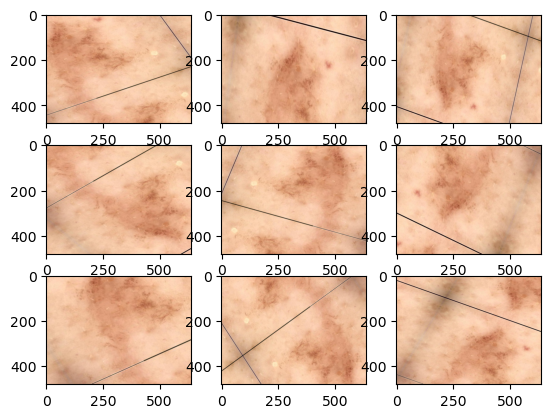

In [39]:
# Loading a single image to demonstrate the augmentations
img = load_img('../data/benign_and_malignant/train/benign/ISIC_3783427.JPG')

# Convert to numpy array
data = img_to_array(img)

# Expand dimension to one sample
samples = np.expand_dims(data, 0)

# Prepare iterator
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
for i in range(9):
    # Define subplot
    plt.subplot(330 + 1 + i)
    
    # Generate batch of images
    batch = it.next()
    
    # Convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # Plot raw pixel data
    plt.imshow(image)

# Show the figure
plt.show()


Notice that one single image has been augmented in many different ways, with it being flipped, zoomed, rotated, and shifted in many different ways.

Each of my original images will be augmented similarly.

In [40]:
# Generate augmented data from my original dataset
augmented_train_data = datagen.flow_from_directory('../data/benign_and_malignant/train/',  # Directory containing training images
                                                   target_size=(224, 224), # Desired image size
                                                   class_mode='binary'     # Binary classification task (benign vs malignant)
                                                  )

Found 9926 images belonging to 2 classes.


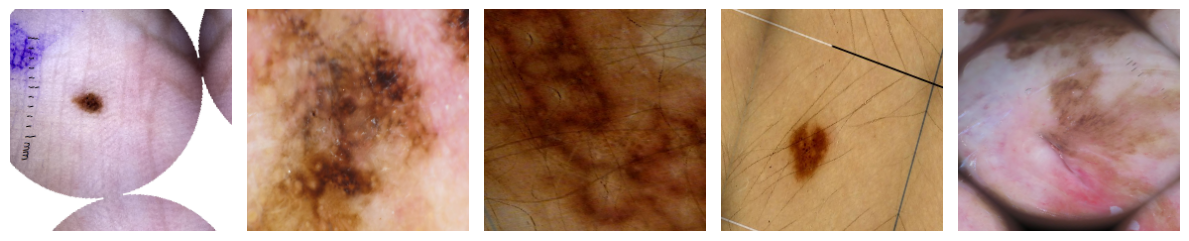

In [41]:
# Generate the augmented images
augmented_images = []
num_images = 5  # Number of images to display

# Iterate over the augmented_train_data generator to obtain the augmented images
for i, (image, label) in enumerate(augmented_train_data):
    augmented_images.append(image)
    if i > num_images:
        break

# Plot the augmented images
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i in range(num_images):
    # Normalize the image data
    normalized_image = augmented_images[i][0] / 255.0
    axes[i].imshow(normalized_image)
    axes[i].axis('off')

plt.tight_layout()
plt.show();


These are the augmented images. Notice that they have had the previously described augmentations (e.g. rotation, zooming in, etc.) applied.

These will be the augmented images that I train the upcoming model with.

In [42]:
# defining learning rate schedule 
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 5: # from epoch 6 onwards, the learning rate will be reduced by a factor of 10.
        lr *= 0.1
    return lr

#defining my learning rate scheduler variable
lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_recall_5', patience=3, mode='max')#monitor my recall score, stops training if after 3 epochs there's no improvement.

In [43]:
# Create our FNN model architecture
trf_model = Sequential() # instantiate empty sequential model using Sequential class

# Then add the pre-trained model to use Transfer Learning, get all the weights from pre_trained_model
trf_model.add(pre_trained_model) # pre_trained_model = input CNN layers

trf_model.add(Dropout(0.5))
trf_model.add(Dense(960,activation = 'relu'))
trf_model.add(BatchNormalization())
trf_model.add(Dense(512,activation = 'relu'))
trf_model.add(BatchNormalization())
trf_model.add(Dense(512,activation = 'relu'))
trf_model.add(Dense(256,activation = 'relu'))
trf_model.add(Dense(1, activation='sigmoid')) # dense 1 layer & activation = 'sigmoid' for binary classification

trf_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 960)               0         
                                                                 
 dense_11 (Dense)            (None, 960)               922560    
                                                                 
 batch_normalization_3 (Batc  (None, 960)              3840      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 512)               492032    
                                                                 
 batch_normalization_4 (Batc  (None, 512)             

In [44]:
# Compile the model
trf_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[Recall()])  
# specify Adam optimizer, binary_crossentropy loss function for a binary classification task, and my targeted metric of recall.

In [45]:
# Fit model on training data (fit model and save results to history)
improved4_history = trf_model.fit(augmented_train_data, # training on the augmented images this time.
                        batch_size=64, 
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation (X, y split internally)
                        epochs=10, # number of epochs has been increased from 5 to 10
                        callbacks=[lr_scheduler,early_stopping] #learning rate will be reduced by a factor of 10 from the 5th epoch onwards
                       )

Epoch 1/10


2023-05-28 20:21:50.235749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - ETA: 0s - loss: 0.3706 - recall_5: 0.7861

2023-05-28 20:23:51.389126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - 162s 509ms/step - loss: 0.3706 - recall_5: 0.7861 - val_loss: 0.4439 - val_recall_5: 0.6157 - lr: 0.0010
Epoch 2/10
311/311 [==============================] - 152s 489ms/step - loss: 0.3158 - recall_5: 0.8008 - val_loss: 0.3739 - val_recall_5: 0.7271 - lr: 0.0010
Epoch 3/10
311/311 [==============================] - 157s 506ms/step - loss: 0.3022 - recall_5: 0.8179 - val_loss: 0.3715 - val_recall_5: 0.7066 - lr: 0.0010
Epoch 4/10
311/311 [==============================] - 153s 492ms/step - loss: 0.2922 - recall_5: 0.8256 - val_loss: 0.3414 - val_recall_5: 0.7842 - lr: 0.0010
Epoch 5/10
311/311 [==============================] - 152s 489ms/step - loss: 0.2925 - recall_5: 0.8287 - val_loss: 0.3448 - val_recall_5: 0.7475 - lr: 0.0010
Epoch 6/10
311/311 [==============================] - 151s 485ms/step - loss: 0.2769 - recall_5: 0.8386 - val_loss: 0.3633 - val_recall_5: 0.7102 - lr: 0.0010
Epoch 7/10
311/311 [==============================] - 151

The results show that the data augmentation actually makes the model perform worse.

A reason for this could be that the variations introduced through augmentation techniques, such as rotations, flips, zooming, etc., may not align with the natural variations found in skin lesions. Skin lesions have no such thing as a 'right side up' like a bottle or a car, making certain augmentation techniques such as rotation or flipping less effective or potentially misleading for training a model on skin lesion classification.

Knowing this, I will stick to using unaugmented images for training the final model.

# Final Model

After trying all of these various improvements:
1. Different pre-trained models
1. Global Max Pooling vs Global Average Pooling
1. Increasing Hidden Layers
1. Increasing Hidden Layers Further
1. Augmented Images with Increased Hidden Layers

The best model that I have so far is actually the baseline model using MobileNetV3. This could be due to the fact that the pre-trained model may already have sufficient complexity and capacity to capture the necessary features and patterns in my skin lesions dataset. 

As such, I will select the baseline model to try one final improvement and use it as the final model.

I will include one dropout layer before the output layer to reduce overfitting, as the baseline model was overfitting by more than 5% which is not acceptable. With the addition of the dropout layer, I aim to reduce overfitting to below 5% and to have good performance as well.

In [46]:
# Create our FNN model architecture
trf_model = Sequential() # instantiate empty sequential model using Sequential class

# Then add the pre-trained model to use Transfer Learning, get all the weights from pre_trained_model
trf_model.add(pre_trained_model) # pre_trained_model = input CNN layers

trf_model.add(Dropout(0.4))

# Taking the 1-D vector output from MobileNetV3Large & use logistic regression classification head to classify benign vs malignant
trf_model.add(Dense(1, activation='sigmoid')) # dense 1 layer & activation = 'sigmoid' for binary classification

trf_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 960)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________


In [47]:
# Compile the model
trf_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[Recall()])  
# specify Adam optimizer, binary_crossentropy loss function for a binary classification task, and my targeted metric of recall

early_stopping = EarlyStopping(monitor='val_recall_6', patience=4, mode='max',restore_best_weights= True)#monitor my recall score, stops training if after 4 epochs there's no improvement.

In [48]:
# Fit model on training data (fit model and save results to history)
final_history = trf_model.fit(train_data, # train_data created using ImageDataGenerator class for model training (X, y split internally)
                        batch_size=64, 
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation (X, y split internally)
                        epochs=15, # number of epochs has been increased from 5 to 15
                        callbacks=[lr_scheduler,early_stopping] #learning rate will be reduced by a factor of 10 from the 5th epoch onwards
                       )

Epoch 1/15


2023-05-28 20:39:51.444041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - ETA: 0s - loss: 0.4203 - recall_6: 0.7718

2023-05-28 20:41:08.980214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - 122s 375ms/step - loss: 0.4203 - recall_6: 0.7718 - val_loss: 0.3956 - val_recall_6: 0.7588 - lr: 0.0010
Epoch 2/15
311/311 [==============================] - 109s 351ms/step - loss: 0.3053 - recall_6: 0.8355 - val_loss: 0.3738 - val_recall_6: 0.8230 - lr: 0.0010
Epoch 3/15
311/311 [==============================] - 110s 353ms/step - loss: 0.2898 - recall_6: 0.8449 - val_loss: 0.3711 - val_recall_6: 0.7870 - lr: 0.0010
Epoch 4/15
311/311 [==============================] - 110s 354ms/step - loss: 0.2754 - recall_6: 0.8535 - val_loss: 0.3483 - val_recall_6: 0.8039 - lr: 0.0010
Epoch 5/15
311/311 [==============================] - 109s 352ms/step - loss: 0.2723 - recall_6: 0.8586 - val_loss: 0.3340 - val_recall_6: 0.8456 - lr: 0.0010
Epoch 6/15
311/311 [==============================] - 110s 352ms/step - loss: 0.2670 - recall_6: 0.8568 - val_loss: 0.3284 - val_recall_6: 0.8427 - lr: 0.0010
Epoch 7/15
311/311 [==============================] - 110

**This is the results of my final model.**

Note that in my early stopping, I included the parameter restore_best_weights = True. This returns me the model with the epoch with the best validation recall score. As such, my final model is using epoch no.5. 

The final model has a recall score of 0.84 and with only 1% overfitting. This is my best model.

Time to evaluate it on the holdout set to see how well it generalizes to unseen data.

# Evaluating Final Model Performance on Holdout Set

In [49]:
evaluation_results = trf_model.evaluate(holdout_data)

45/45 [==============================] - 11s 233ms/step - loss: 0.2108 - recall_6: 0.9633


The recall score on the holdout data is good. The recall score is 0.9633.

In [50]:
y_true = holdout_data.labels # getting my y_true
y_pred_prob = trf_model.predict(holdout_data).flatten()
y_pred = tf.cast(y_pred_prob>0.5, tf.int32) # getting my y_pred 

2023-05-28 20:56:39.412667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 13s 236ms/step


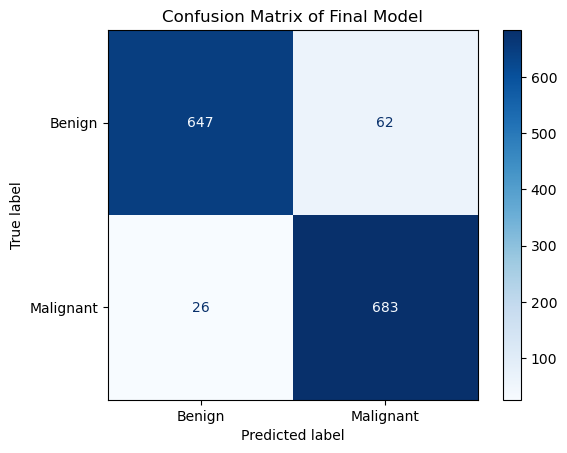

In [52]:
disp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred,display_labels=['Benign','Malignant'],cmap='Blues');

disp.ax_.set_title('Confusion Matrix of Final Model');

In [51]:
print(classification_report(y_true,y_pred,target_names=['Benign','Malignant'])) # printing classification report

              precision    recall  f1-score   support

      Benign       0.96      0.91      0.94       709
   Malignant       0.92      0.96      0.94       709

    accuracy                           0.94      1418
   macro avg       0.94      0.94      0.94      1418
weighted avg       0.94      0.94      0.94      1418



As can be seen from the confusion matrix and the classification report above. The final model has both a good recall score and precision score.

The recall score of 0.96 indicates that the model is able to correctly identify 96% of the positive instances in the dataset. This means that the model has a high sensitivity in detecting the positive samples and minimizing the number of false negatives.

A high recall score in the context of this problem statement is crucial as it ensures that the model is effective in identifying malignant skin lesions. With a recall score of 0.96, the model is able to capture a significant proportion of the actual malignant cases, reducing the risk of missing potentially harmful lesions and allowing for early detection and appropriate medical intervention.

In [54]:
#Saving the model
trf_model.save('benign_malignant_final_model.h5') 

Saving the model for model deployment.

# Model Deployment

The final model was deployed using streamlit. Please refer to the 2nd code note book titled 02_Model_Deployment for the code, and the app can be found below.

[![Streamlit App](https://static.streamlit.io/badges/streamlit_badge_black_white.svg)](https://btanyh-streamlit-apps-skin-lesion-classifier-f4yhts.streamlit.app/)



# Conclusion

A summary of model performance can be found below as well as the conclusion for this project.

<table><thead><tr><th colspan="7">Note: For a full breakdown on the hyperparameters for each model (number of epochs, batch size, type of global pooling layer, etc.), as well as the specific differences between each model, please view the code notebook.</th></tr></thead><tbody><tr><td>Model</td><td>Baseline Model - MobileNetV3</td><td>Improved Model #1</td><td>Improved Model #2</td><td>Improved Model #3</td><td>Improved Model #4</td><td>Final Model</td></tr><tr><td>Main Difference from previous model</td><td>Pre-trained model straight to <br>output layer</td><td>Global Max Pooling instead of<br>Global Average Pooling</td><td>Increasing number of<br>hidden layers</td><td>Even more hidden <br>layers</td><td>Augmentation of Images </td><td>Pre-trained model<br> with dropout layer <br>included</td></tr><tr><td>Train Recall Score</td><td>0.87</td><td>0.87</td><td>0.85</td><td>0.85</td><td>0.83</td><td>0.85</td></tr><tr><td>Validation Recall Score</td><td>0.81</td><td>0.73</td><td>0.77</td><td>0.76</td><td>0.69</td><td>0.84</td></tr><tr><td>Holdout Recall Score</td><td>n.a</td><td>n.a</td><td>n.a</td><td>n.a</td><td>n.a</td><td>0.96</td></tr></tbody></table>

In this project, I aimed to develop and deploy a highly accurate neural network model for the identification of benign and malignant skin lesions, with the ultimate goal of providing a reliable and accessible tool to the general public for skin lesion assessment. By leveraging machine learning techniques, we aimed to address the global burden of skin cancer, improve early detection, and contribute to improved healthcare outcomes worldwide.

The final model achieved a recall score of 0.96, indicating its high ability to identify malignant skin lesions correctly. This performance metric is crucial for our problem statement, as the priority lies in correctly identifying as many actual positives (malignant cases) as possible to ensure timely medical attention and reduce mortality rates associated with melanoma.
The model's high recall score demonstrates its effectiveness in distinguishing between benign and malignant skin lesions, offering a valuable tool for the general public. With the integration of this model into a user-friendly smartphone app, individuals can now capture images of skin lesions and assess the need for a doctor's visit based on the model's predictions rather than relying solely on their own untrained judgment. This empowers users to seek medical attention promptly when necessary, potentially improving treatment outcomes and reducing healthcare costs associated with delayed diagnosis.

As such, the objective of this project has been achieved.

# Recommendations for Future Works

As to how future works can be improved, I have the following suggestions:

1. More image preprocessing can be done. Such as standardising the brightness across the images, contrast adjustment, or even removing the hairs from the images which block the important part of the image which is the skin lesion.

2. More advanced pre-trained models could be used instead of MobileNetV3. As I chose MobileNetV3 partly due to the fact that I did not have a lot of computational power to work with and as such had to choose a model which I could run. Future works could work with more complicated models such as EfficietNetV2L which has over 119 million parameters and achieved the [best accuracy score out of all Keras applications so far.](https://keras.io/api/applications/)

3. Obtaining and incorporating diverse datasets that encompass a broader range of skin tones in order to improve the model's robustness and fairness in real-world applications. As previously discussed, the current model was trained predominantly of skin lesions on white skin, future models should be trained on a more diverse dataset consisting of various skin tones.